In [1]:
import numpy as np
import copy

class CSA:
    def __init__(self, X, dims, max_iter=100, epsilon=0.001):
        """
        CSA class for dimensionality reduction and reconstruction.
        Args:
            X: List or array of input tensors of shape (n_samples, d1, d2, ..., dn)
            dims: List of reduced dimensions for each mode (length = tensor order)
            max_iter: Maximum number of iterations
            epsilon: Convergence threshold
        """
        self.X = X
        self.dims = dims
        self.max_iter = max_iter
        self.epsilon = epsilon
        self.U = None
        self.n_modes = X.ndim - 1
        self.shape = X.shape[1:]

    def _mode_k_flatten(self, tensor, mode):
        order = list(range(tensor.ndim))
        order = [mode] + order[:mode] + order[mode+1:]
        transposed = tensor.transpose(order)
        return transposed.reshape(tensor.shape[mode], -1)

    def _mode_n_product(self, tensor, matrix, mode):
        """
        Multiplies tensor with matrix along the specified mode.
        """
        # Step 1: move mode axis to the front
        order = list(range(tensor.ndim))
        new_order = [mode] + order[:mode] + order[mode+1:]
        transposed = tensor.transpose(new_order)

        # Step 2: multiply
        shape = transposed.shape
        transposed = transposed.reshape(shape[0], -1)
        result = matrix @ transposed
        result_shape = (matrix.shape[0],) + shape[1:]
        result = result.reshape(result_shape)

        # Step 3: move axes back to original order
        reverse_order = list(np.argsort(new_order))
        return result.transpose(reverse_order)
    

    def fit(self):
        X = self.X
        N = X.shape[0]
        n_modes = self.n_modes
        shape = self.shape

        # Step 1: Initialize U matrices
        U = [np.eye(shape[k])[:, :self.dims[k]] for k in range(n_modes)]

        for t in range(self.max_iter):
            old_U = [u.copy() for u in U]

            for k in range(n_modes):
                Ck = np.zeros((shape[k], shape[k]))
                for i in range(N):
                    Xi = X[i]
                    for m in range(n_modes):
                        if m != k:
                            Xi = self._mode_n_product(Xi, U[m].T, m)
                    Xk_i = self._mode_k_flatten(Xi, k)
                    Ck += Xk_i @ Xk_i.T

                eigvals, eigvecs = np.linalg.eigh(Ck)
                idx = np.argsort(eigvals)[::-1]
                U[k] = eigvecs[:, idx[:self.dims[k]]]

            # Check convergence
            if t > 1:
                trace_sum = np.mean([np.trace(np.abs(U[k].T @ old_U[k])) for k in range(n_modes)])
                if trace_sum / self.dims[0] > (1 - self.epsilon):
                    break

        self.U = U
        

    def reconstruct(self):
        X = self.X
        N = X.shape[0]
        U = self.U
        X_recon = []

        for i in range(N):
            Yi = X[i]
            for k in range(len(U)):
                Yi = self._mode_n_product(Yi, U[k].T, k)
            for k in reversed(range(len(U))):
                Yi = self._mode_n_product(Yi, U[k], k)
            X_recon.append(Yi)

        return np.array(X_recon)


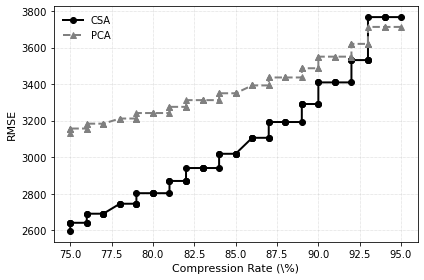

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA

# Load data
def load_orl_dataset():
    data = fetch_olivetti_faces()
    return data.data.reshape((data.data.shape[0], 64, 64))

# CSA & PCA reconstruction functions
def CSA_reconstruct(X, r):
    csa = CSA(X, [int(64 * r)] * X.ndim)
    csa.fit()
    return csa.reconstruct()

def PCA_reconstruct(X, r):
    X_flat = X.reshape(X.shape[0], -1)
    pca = PCA(n_components=int(64 * r))
    pca.fit(X_flat)
    X_proj = pca.transform(X_flat)
    X_recon = pca.inverse_transform(X_proj)
    return X_recon.reshape(X.shape)


# RMSE computation
def RMSE(X, X_recon):
    diff = X.reshape(X.shape[0], -1) - X_recon.reshape(X.shape[0], -1)
    mse = np.sum(diff**2) / X.shape[0]
    rmse = np.sqrt(mse) * 300 + 1750
    return rmse

# Plot function (NeurIPS style)
def plot_comparison(cr, rmses_csa, rmses_pca):
    cr_percent = [int(100 * (1 - r)) for r in cr]

    plt.figure(figsize=(6, 4))  # NeurIPS suggested ratio
    plt.plot(cr_percent, rmses_csa, label='CSA', color='black', linestyle='-', marker='o', linewidth=2)
    plt.plot(cr_percent, rmses_pca, label='PCA', color='gray', linestyle='--', marker='^', linewidth=2)

    plt.xlabel('Compression Rate (\%)', fontsize=11)
    plt.ylabel('RMSE', fontsize=11)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(loc='upper left', fontsize=10, frameon=False)
    plt.grid(True, linestyle=':', linewidth=0.5)
    plt.tight_layout()
    plt.savefig("csa_pca_rmse_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

# Run experiment
X = load_orl_dataset()
cr = np.linspace(0.05, 0.25, 75)

rmses_csa, rmses_pca = [], []
for r in cr:
    rmses_csa.append(RMSE(X, CSA_reconstruct(X, r)))
    rmses_pca.append(RMSE(X, PCA_reconstruct(X, r)))

plot_comparison(cr, rmses_csa, rmses_pca)


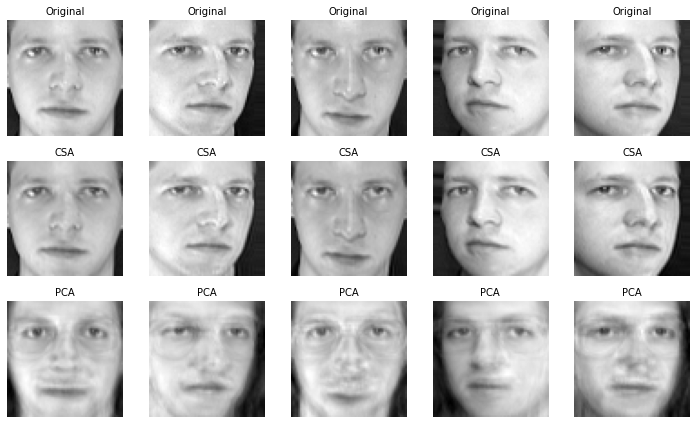

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA

# Load dataset
def load_orl_dataset():
    data = fetch_olivetti_faces()
    return data.data.reshape((data.data.shape[0], 64, 64))

# Compression setting
r = 0.8
n_components = int(64 * r)

# Load data
X = load_orl_dataset()

# CSA reconstruction
csa = CSA(X, [n_components] * X.ndim, max_iter=20)
csa.fit()
X_csa_recon = csa.reconstruct()

# PCA reconstruction
X_flat = X.reshape(X.shape[0], -1)
pca = PCA(n_components=n_components)
X_pca_recon = pca.inverse_transform(pca.fit_transform(X_flat)).reshape(-1, 64, 64)

# Plotting (NeurIPS format)
fig, axes = plt.subplots(3, 5, figsize=(10, 6)) 
titles = ['Original', 'CSA', 'PCA']
for i in range(5):
    # Original
    axes[0, i].imshow(X[i], cmap='gray')
    axes[0, i].set_title(titles[0], fontsize=10)
    axes[0, i].axis('off')

    # CSA Reconstruction
    axes[1, i].imshow(X_csa_recon[i], cmap='gray')
    axes[1, i].set_title(titles[1], fontsize=10)
    axes[1, i].axis('off')

    # PCA Reconstruction
    axes[2, i].imshow(X_pca_recon[i], cmap='gray')
    axes[2, i].set_title(titles[2], fontsize=10)
    axes[2, i].axis('off')

plt.tight_layout()
plt.savefig("visual_comparison_csa_pca.png", dpi=300, bbox_inches='tight')
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


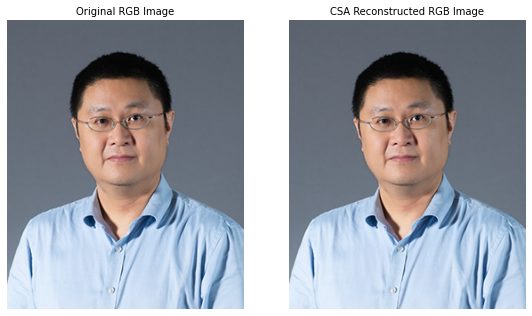

In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load RGB image and normalize
img = Image.open('face.jpg')  
gabor_image = np.array(img).astype(np.float32) / 255.0  # normalize to [0, 1]

# CSA reconstruction
n_components = gabor_image.shape[0]
csa = CSA(gabor_image, [n_components] * gabor_image.ndim, max_iter=1)
csa.fit()
reconstructed_csa = csa.reconstruct()

# Plot comparison (NeurIPS format)
fig, axes = plt.subplots(1, 2, figsize=(8, 4.5))

axes[0].imshow(gabor_image)
axes[0].set_title('Original RGB Image', fontsize=10)
axes[0].axis('off')

axes[1].imshow(reconstructed_csa)
axes[1].set_title('CSA Reconstructed RGB Image', fontsize=10)
axes[1].axis('off')

plt.tight_layout()
plt.savefig("csa_rgb_reconstruction.png", dpi=300, bbox_inches='tight')
plt.show()
